In [65]:
import fiftyone as fo
import fiftyone.zoo as foz

classes_to_keep = [
    "person",
    "bicycle",
    "car",
    "motorcycle",
    "airplane",
]

train_dataset_name = "train1"
if train_dataset_name in fo.list_datasets():
    # Delete the existing dataset
    fo.Dataset(train_dataset_name).delete()

val_dataset_name = "val1"
if val_dataset_name in fo.list_datasets():
    # Delete the existing dataset
    fo.Dataset(val_dataset_name).delete()

train_dataset = foz.load_zoo_dataset(
    "coco-2017",
    label_types=["detections"],
    split="train",
    classes=classes_to_keep,
    max_samples=1000,
    shuffle=True,
    seed=123,
    only_matching=True,
    num_workers=10,
    dataset_name=train_dataset_name,
)

val_dataset = foz.load_zoo_dataset(
    "coco-2017",
    label_types=["detections"],
    split="validation",
    classes=classes_to_keep,
    max_samples=100,
    shuffle=True,
    seed=123,
    only_matching=True,
    num_workers=10,
    dataset_name=val_dataset_name,
)


 100% |██████|    1.9Gb/1.9Gb [9.9s elapsed, 0s remaining, 209.8Mb/s]      
Extracting annotations to '/home/yipeng/fiftyone/coco-2017/raw/instances_train2017.json'
 100% |████████████████| 1000/1000 [1.1m elapsed, 0s remaining, 15.0 images/s]      
Writing annotations for 1000 downloaded samples to '/home/yipeng/fiftyone/coco-2017/train/labels.json'
Dataset info written to '/home/yipeng/fiftyone/coco-2017/info.json'
Loading 'coco-2017' split 'train'
 100% |███████████████| 1000/1000 [1.9s elapsed, 0s remaining, 519.1 samples/s]      
Dataset 'train1' created
Found annotations at '/home/yipeng/fiftyone/coco-2017/raw/instances_val2017.json'
 100% |██████████████████| 100/100 [6.9s elapsed, 0s remaining, 15.6 images/s]      
Writing annotations for 100 downloaded samples to '/home/yipeng/fiftyone/coco-2017/validation/labels.json'
Dataset info written to '/home/yipeng/fiftyone/coco-2017/info.json'
Loading 'coco-2017' split 'validation'
 100% |█████████████████| 100/100 [204.6ms elapsed, 0

In [67]:
train_data = train_dataset
val_data = val_dataset

In [ ]:
# import os
# import cv2 as cv
#
# output_dir = "resized_dataset"
# os.makedirs(output_dir, exist_ok=True)
#
# resized_image_size = (224, 224)
#
# def resize_image_and_annotations(sample):
#
#     # Resize image
#     image_path = sample.filepath
#     image = cv.imread(image_path)
#     height, width = image.shape[:2]
#     image = cv.resize(image, resized_image_size)
#
#     # Update the file path
#     resized_image_path = os.path.join(output_dir, os.path.basename(image_path))
#     sample.filepath = resized_image_path
#
#     # Save the resized image
#     cv.imwrite(resized_image_path, image)
#
#     # Update the bounding boxes
#     scale_x = resized_image_size[0] / float(width)
#     scale_y = resized_image_size[1] / float(height)
#
#     for det in sample["ground_truth"].detections:
#         x1, y1, x2, y2 = det.bounding_box
#         x1 = x1 * scale_x
#         x2 = x2 * scale_x
#         y1 = y1 * scale_y
#         y2 = y2 * scale_y
#         det.bounding_box = [x1, y1, x2, y2]
#
#     sample.save()
#
# for sample in train_data:
#     resize_image_and_annotations(sample)
#
# for sample in val_data:
#     resize_image_and_annotations(sample)
#


In [68]:
import tensorflow as tf

def sample_to_image_tensor(sample):
    image_path = sample.filepath
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

def sample_to_bbox_tensor(sample):
    bboxes = []
    for det in sample["ground_truth"].detections:
        x1, y1, x2, y2 = det.bounding_box
        bboxes.append([y1, x1, y2, x2])  # TensorFlow format: [ymin, xmin, ymax, xmax]
    return tf.convert_to_tensor(bboxes, dtype=tf.float32)

def sample_to_label_tensor(sample, classes_to_idx):
    labels = []
    for det in sample["ground_truth"].detections:
        labels.append(classes_to_idx[det.label])
    return tf.convert_to_tensor(labels, dtype=tf.int64)


def sample_to_tensors(sample, classes_to_idx):
    image = sample_to_image_tensor(sample)
    bboxes = sample_to_bbox_tensor(sample)
    labels = sample_to_label_tensor(sample, classes_to_idx)
    return image, (bboxes, labels)

def dataset_generator(fiftyone_dataset, classes_to_idx):
    for sample in fiftyone_dataset:
        yield sample_to_tensors(sample, classes_to_idx)



In [69]:
classes_to_idx = {c: i for i, c in enumerate(classes_to_keep)}

train_tf_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_generator(train_data, classes_to_idx),
    output_signature=(
        tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
        (
            tf.TensorSpec(shape=(None, 4), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.int64),
        )
    )
)

val_tf_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_generator(val_data, classes_to_idx),
    output_signature=(
        tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
        (
            tf.TensorSpec(shape=(None, 4), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.int64),
        )
    )
)


In [70]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_tf_sample(image, bboxes, labels, idx_to_classes):
    image = np.array(image, dtype=np.uint8)
    bboxes = np.array(bboxes)
    labels = np.array(labels)

    plt.imshow(image)
    ax = plt.gca()

    for i, bbox in enumerate(bboxes):
        ymin, xmin, ymax, xmax = bbox
        width = xmax - xmin
        height = ymax - ymin
        rect = plt.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        label = idx_to_classes[labels[i]]
        ax.text(xmin, ymin, label, fontsize=12, color='w', bbox=dict(facecolor='r', edgecolor='r', alpha=0.5))

    plt.show()


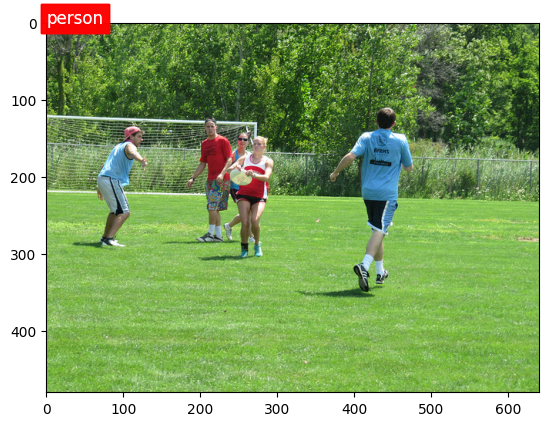

In [73]:
idx_to_classes = {i: c for i, c in enumerate(classes_to_keep)}

for image, (bboxes, labels) in train_tf_dataset.shuffle(1000).take(1):
    visualize_tf_sample(image, bboxes, labels, idx_to_classes)
